## Project: Computer simulation of a roadblock model of translational control

## rini v0.81 (Extras Jupyter notebook)

## Author: Gabin ROUSSEAU

This notebook contains a copy of the rini and corini code, followed by various functions used to explore the model but that were cut from the final dissertation's content.


---
_roadblock_ini - v0.81_

In [3]:
#Core function for the model
def rini(t=500, L=5, l=1, a=0.75, b=0.75, p=1, k_on=0.5, k_off=0.5, l_rb=1, B_i=[]):
    '''
    
    roadblock_ini v0.81
    (rini for short)
    
    DESCRIPTION:
    This is the 0.81 version of Gabin ROUSSEAU's model for the roadblock effect of mRNA-binding Ssd1 on translation initiation in S. cerevisiae.
    
    -->Runs an inhomogeneous TASEP model of user-defined parameters that allows for a set particle of variable length, to which the exclusion process adapts. Dynamic and targeted roadblock can similarly vary in size.
    Returns a dataset containing for each time point:
    1 - The total number of particles that initiated up to that time point "passed_total". (i.e., passed through the lattice. Not to be confused with loading, where a particle enters the lattice. Named so because we model after the ribosome PIC.)
    2 - The state of each lattice site Si (0 or 1). i = 1 ,..., L
    3 - The lattice-wide density d = number of particles / L. Measured at the end of an iteration.
    
    ARGUMENTS: t, L, l, a, b, p
    t:     number of iterations to run the TASEP model; DEFAULT: t=500
    L:     lattice length;                              DEFAULT: L=5
    l:     particle length;                             DEFAULT: l=1
    a:     rate of loading;                             DEFAULT: a=0.75
    b:     rate of unloading;                           DEFAULT: b=0.75
    p:     rate of scanning (i.e., site hopping);       DEFAULT: p=1
    k_on:  rate of blocking;                            DEFAULT: k_on=0.5
    k_off: rate of unblocking;                          DEFAULT: k_off=0.5
    l_rb:  roadblock length;                            DEFAULT: l_rb=1
    B_i:   blockable lattice index list;                DEFAULT: B_i=[]
    
    
    '''
    
    #set initial variables
    S_start=0
    C=[] #Lattice configuration
    B=[] #Blocking subconfiguration
    B_i.sort() #sort B_i in ascending order
    P=[] #Site hopping rates
    A=[a] #Gillespie propensities
    for i in range(L):
        C.append(S_start)
        B.append(S_start)
        if i < L-1:
            P.append(p)
        if i > 0: #to not overwrite A0=a
            if i < L-1:
                A.append(C[i]*P[i])
            else:
                A.append(0)
                
    for i in B_i:
        A.append(k_on)
        A.append(0) #k_off position
    
    
   
    passed_total=0 #counter for particles that terminated scanning
    
    #prepare returned dataset
    rini_data={'time':[0], 'passed_total':[0], 'density':[0]}
    loc1=0
    #update with all site configurations
    for S in C:
        loc1+=1
        rini_data.update({f'S{loc1}':[0]})
    #update with all block configurations    
    for i in B_i:
        rini_data.update({f'B{i+1}':[0]})
        
    
    #exclusion rule variables
    S_condition_0=C[0:l]
    B_condition_0=C[0:l_rb]
    
    #time tracker to compare against t
    time = 0
    
    #launch model
    while time <= t:
            #Rolling the random numbers for stochasticity
            R=sum(A)
            if R>0:
                r1=np.random.exponential(1/R)
                r2=np.random.uniform(0,1)*R
                time+=r1
                #determining which site is acted upon
                i = 0 #preparing the index of the moved particle
                r = 0.0 #iterative value that serves to pinpoint the index (rmax=R)
                while r < r2:
                    r += A[i]
                    i += 1
                i-=1

                #LOADING
                if i==0 and C[i]==0:
                    C[0]+=1

                #SCANNING
                elif i<L-1 and C[i]==1:
                    C[i]-=1
                    C[i+1]+=1
                    A[i]=0 #reset propensity for the current move

                #UNLOADING
                elif i==L-1 and C[i]==1:
                    C[i]-=1
                    passed_total+=1
                    A[i]=0 #reset propensity for the current move
                    
                    
                #BLOCKING/UNBLOCKING
                elif i>L-1:
                    i-=L
                    #blocking
                    if (i%2)==0:
                        blocked=B_i[int(i/2)]
                        B[blocked]+=1
                        A[i+L+1]=k_off #instantly flag the site as being unblockable
                    #unblocking
                    else:
                        unblocked=B_i[int((i-1)/2)]
                        B[unblocked]-=1
                        A[i+L]=0
    
                else:
                    print(f'An unexpected error happened at time {time}, please check the code because i={i}, A[i]={A[i]} and R={R}.')

                #UPDATING PROPENSITIES FOR THE NEXT ITERATION: LOADING, PARTICLES AND BLOCKS
                particles=[index for index in range(len(C)) if C[index] == 1]

                #load-ready?
                if C[0]==0:
                    if S_condition_0==C[0:l] and B_condition_0==B[0:l_rb]:
                        A[0]=a
                    else:
                        A[0]=0


                #particle check
                for particle in particles:
                    #unload-ready?
                    if particle==L-1:
                        A[particle]=b
                    #scan-ready?                       
                    
                    else: 
                        particle_token=0 #0 means a particle is ahead
                        roadblock_token=0 #0 means a roadblock is ahead
                        #particle checkpoint
                        if particle <= L-l-1: #can it be blocked by another particle?
                            if C[particle+l]==0: #is it not blocked by a particle?
                                particle_token=1
                        else: #can't be blocked by a particle
                            particle_token=1
                            
                                
                        #roadblock checkpoint
                        if particle <= L-l_rb-1: #can it be blocked by a roadblock?
                            if B[particle+l_rb]==0: #is it not blocked by a roadblock?
                                roadblock_token=1
                        else: #can't be blocked by a roadblock
                            roadblock_token=1
                        
                        #token validation
                        if particle_token==1 and roadblock_token==1:
                            A[particle]=P[particle]
                        else:#something is blocking the particle
                            A[particle]=0
                
                #block-ready?
                for block_ii in range(len(B_i)): #loop through block subindicies (index in the configuration index list)
                    block_i=B_i[block_ii] #get the configuration index
                    #restriction rule for blocking to be possible: depends on particle and block length, assumes the tracking site is at the head of all particles/blocks for rule simplicity.
                    
                    if block_i-l_rb+1 >=0: #if a site is place too close to the entry, this value would be negative, this condition takes this scenario into account
                        if 1 not in C[block_i-l_rb+1:block_i+l] and 1 not in B[block_i-l_rb+1:block_i+l_rb]:
                            A[L+(block_ii*2)]=k_on
                        else:
                            A[L+(block_ii*2)]=0
                    else:
                        if 1 not in C[0:block_i+l] and 1 not in B[0:block_i+l_rb]:
                            A[L+(block_ii*2)]=k_on
                        else:
                            A[L+(block_ii*2)]=0
                        

                    
                    
            
                #update dataset
                
                if time <= t:
                    rini_data.setdefault('time', []).append(time)
                elif time > t: #force the final time point to be at time=t if t is exceeded at the end of the run
                    rini_data.setdefault('time', []).append(t)

                rini_data.setdefault('passed_total', []).append(passed_total)

                particle_count=0

                loc3=0
                for S in C:
                    loc3+=1
                    rini_data.setdefault(f'S{loc3}', []).append(S)
                    if S==1:
                        particle_count+=1

                d=round(particle_count/L,2) #lattice density rounded to 2 decimals
                rini_data.setdefault('density', []).append(d)
                
                for i in B_i:
                    rini_data.setdefault(f'B{i+1}', []).append(B[i])
            
            else: #break the loop early to avoid errors in case no action is possible (which should only happen if a rate is null)
                #update dataset
                rini_data.setdefault('time', []).append(t)

                rini_data.setdefault('passed_total', []).append(passed_total)

                particle_count=0

                loc3=0
                for S in C:
                    loc3+=1
                    rini_data.setdefault(f'S{loc3}', []).append(S)
                    if S==1:
                        particle_count+=1

                d=round(particle_count/L,2) #lattice density rounded to 2 decimals
                rini_data.setdefault('density', []).append(d)
                
                for i in B_i:
                    rini_data.setdefault(f'B{i+1}', []).append(B[i])
                break

            #END OF ITERATION
            
            
                
        
    return pd.DataFrame(data=rini_data)

In [5]:
#Core function for the model
def corini(t=500, L=5, l=1, a=0.75, b=0.75, p=1, k_on=0.5, k_off=0.5, l_rb=1, B_i=[], coop_p=0.4, coop_m=0.4, coop_d=1):
    '''
    
    roadblock_ini v0.81 
    (rini for short)
    
    DESCRIPTION:
    This is the 0.81 co-operative version of Gabin ROUSSEAU's model for the roadblock effect of mRNA-binding Ssd1 on translation initiation in S. cerevisiae. As it is "cooperative", it assumes block dynamics are cooperative rather than independent in the base model.
    Variables are the same as rini with three additions.
    coop_p: coop "plus", strength of the coop effect on k_on;   DEFAULT: coop_p = 0.4
    coop_m: coop "minus", strength of the coop effect on k_off; DEFAULT: coop_m = 0.4
    coop_d: coop "distance, area of effect multiplied by l_rb"; DEFAULT: coop_d = 1
    
    '''
    
    #set initial variables
    S_start=0
    C=[] #Lattice configuration
    B=[] #Blocking subconfiguration
    B_i.sort() #sort B_i in ascending order
    P=[] #Site hopping rates
    A=[a] #Gillespie propensities
    for i in range(L):
        C.append(S_start)
        B.append(S_start)
        if i < L-1:
            P.append(p)
        if i > 0: #to not overwrite A0=a
            if i < L-1:
                A.append(C[i]*P[i])
            else:
                A.append(0)
                
    for i in B_i:
        A.append(k_on)
        A.append(0) #k_off position
        A.append(0) #k_on coop
        A.append(0) #k_off coop
    
    #coop parameter limiting
    if k_on+coop_p>1: #coop_p is too high, set it to the allowed maximum
        coop_p=1-k_on
        
    if k_off-coop_m<0: #coop_m is too high, set it to the allowed maximum
        coop_m=k_off
    
    
   
    passed_total=0 #counter for particles that terminated scanning
    
    #prepare returned dataset
    rini_data={'time':[0], 'passed_total':[0], 'density':[0]}
    loc1=0
    #update with all site configurations
    for S in C:
        loc1+=1
        rini_data.update({f'S{loc1}':[0]})
    #update with all block configurations    
    for i in B_i:
        rini_data.update({f'B{i+1}':[0]})
        
    
    #exclusion rule variables
    S_condition_0=C[0:l]
    B_condition_0=C[0:l_rb]
    
    #time tracker to compare against t
    time = 0
    
    #launch model
    while time <= t:
            #Rolling the random numbers for stochasticity
            R=sum(A)
            if R>0:
                r1=np.random.exponential(1/R)
                r2=np.random.uniform(0,1)*R
                time+=r1
                #determining which site is acted upon
                i = 0 #preparing the index of the moved particle
                r = 0.0 #iterative value that serves to pinpoint the index (rmax=R)
                while r < r2:
                    r += A[i]
                    i += 1
                i-=1

                #LOADING
                if i==0 and C[i]==0:
                    C[0]+=1

                #SCANNING
                elif i<L-1 and C[i]==1:
                    C[i]-=1
                    C[i+1]+=1
                    A[i]=0 #reset propensity for the current move

                #UNLOADING
                elif i==L-1 and C[i]==1:
                    C[i]-=1
                    passed_total+=1
                    A[i]=0 #reset propensity for the current move
                    
                    
                #BLOCKING/UNBLOCKING
                elif i>L-1:
                    i-=L
                    #blocking
                    if (i%4)==0:
                        blocked=B_i[int(i/4)]
                        B[blocked]+=1
                        A[i+L]=0
                    #unblocking
                    elif ((i-1)%4)==0:
                        unblocked=B_i[int((i-1)/4)]
                        B[unblocked]-=1
                        A[i+L]=0
                    #coop blocking
                    elif ((i-2)%4)==0:
                        blocked=B_i[int((i-2)/4)]
                        B[blocked]+=1
                        A[i+L]=0
                    #coop unblocking
                    elif ((i-3)%4)==0:
                        unblocked=B_i[int((i-3)/4)]
                        B[unblocked]-=1
                        A[i+L]=0
                else:
                    print(f'An unexpected error happened at time {time}, please check the code because i={i}, A[i]={A[i]} and R={R}.')

                #UPDATING PROPENSITIES FOR THE NEXT ITERATION: LOADING, PARTICLES AND BLOCKS
                particles=[index for index in range(len(C)) if C[index] == 1]
            
                #load-ready?
                if C[0]==0:
                    if S_condition_0==C[0:l] and B_condition_0==B[0:l_rb]:
                        A[0]=a
                    else:
                        A[0]=0


                #particle check
                for particle in particles:
                    #unload-ready?
                    if particle==L-1:
                        A[particle]=b
                    #scan-ready?                       
                    
                    else: 
                        particle_token=0 #0 means a particle is ahead
                        roadblock_token=0 #0 means a roadblock is ahead
                        #particle checkpoint
                        if particle <= L-l-1: #can it be blocked by another particle?
                            if C[particle+l]==0: #is it not blocked by a particle?
                                particle_token=1
                        else: #can't be blocked by a particle
                            particle_token=1
                            
                                
                        #roadblock checkpoint
                        if particle <= L-l_rb-1: #can it be blocked by a roadblock?
                            if B[particle+l_rb]==0: #is it not blocked by a roadblock?
                                roadblock_token=1
                        else: #can't be blocked by a roadblock
                            roadblock_token=1
                        
                        #token validation
                        if particle_token==1 and roadblock_token==1:
                            A[particle]=P[particle]
                        else:#something is blocking the particle
                            A[particle]=0
                
                #block-ready?
                for block_ii in range(len(B_i)): #loop through block subindicies (index in the configuration index list)
                    block_i=B_i[block_ii] #get the configuration index
                    #restriction rule for blocking to be possible: depends on particle and block length, assumes the tracking site is at the head of all particles/blocks for rule simplicity.
                    
                    if block_i-l_rb+1 >=0: #if a site is placed too close to the entry, this value would be negative, this condition takes this scenario into account
                        if 1 not in C[block_i-l_rb+1:block_i+l] and 1 not in B[block_i-l_rb+1:block_i+l_rb]:
                            #COOP-ON EFFECT?
                            if block_i-(l_rb*coop_d) < 0: #this first condition prevents unintended indexing at negative values when calculating cooperativity distance
                                if 1 in B[0:block_i-l_rb+1] or 1 in B[block_i+l_rb:block_i+1+(l_rb*coop_d)]:
                                    A[L+(block_ii*4)+2]=k_on+coop_p
                                    A[L+(block_ii*4)]=0
                                else:
                                    A[L+(block_ii*4)]=k_on
                                    A[L+(block_ii*4)+2]=0
                            elif 1 in B[block_i-(l_rb*coop_d):block_i-l_rb+1] or 1 in B[block_i+l_rb:block_i+1+(l_rb*coop_d)]:
                                A[L+(block_ii*4)+2]=k_on+coop_p
                                A[L+(block_ii*4)]=0
                            else:
                                A[L+(block_ii*4)]=k_on
                                A[L+(block_ii*4)+2]=0
                        elif B[block_i]==1:
                            #COOP-OFF EFFECT?
                            if block_i-(l_rb*coop_d) < 0:
                                if 1 in B[0:block_i-l_rb+1] or 1 in B[block_i+l_rb:block_i+1+(l_rb*coop_d)]:
                                    A[L+(block_ii*4)+3]=k_off-coop_m
                                    A[L+(block_ii*4)+1]=0
                                else:
                                    A[L+(block_ii*4)+1]=k_off
                                    A[L+(block_ii*4)+3]=0
                            
                            elif 1 in B[block_i-(l_rb*coop_d):block_i-l_rb+1] or 1 in B[block_i+l_rb:block_i+1+(l_rb*coop_d)]:
                                A[L+(block_ii*4)+3]=k_off-coop_m
                                A[L+(block_ii*4)+1]=0
                            else:
                                A[L+(block_ii*4)+1]=k_off
                                A[L+(block_ii*4)+3]=0
                                
                    else:
                        if 1 not in C[0:block_i+l] and 1 not in B[0:block_i+l_rb]:
                            #COOP-ON EFFECT?
                            if 1 in B[block_i+l_rb:block_i+1+(l_rb*coop_d)]:
                                A[L+(block_ii*4)+2]=k_on+coop_p
                                A[L+(block_ii*4)]=0
                            else:
                                A[L+(block_ii*4)]=k_on
                                A[L+(block_ii*4)+2]=0
                        elif B[block_i]==1:
                            #COOP-OFF EFFECT?
                            if 1 in B[block_i+l_rb:block_i+1+(l_rb*coop_d)]:
                                A[L+(block_ii*4)+3]=k_off-coop_m
                                A[L+(block_ii*4)+1]=0
                            else:
                                A[L+(block_ii*4)+1]=k_off
                                A[L+(block_ii*4)+3]=0
                        

                    
                    
                #update dataset
                
                if time <= t:
                    rini_data.setdefault('time', []).append(time)
                elif time > t: #force the final time point to be at time=t if t is exceeded at the end of the run
                    rini_data.setdefault('time', []).append(t)

                rini_data.setdefault('passed_total', []).append(passed_total)

                particle_count=0

                loc3=0
                for S in C:
                    loc3+=1
                    rini_data.setdefault(f'S{loc3}', []).append(S)
                    if S==1:
                        particle_count+=1

                d=round(particle_count/L,2) #lattice density rounded to 2 decimals
                rini_data.setdefault('density', []).append(d)
                
                for i in B_i:
                    rini_data.setdefault(f'B{i+1}', []).append(B[i])
            
            else: #break the loop early to avoid errors in case no action is possible (which should only happen if a rate is null)
                #update dataset
                rini_data.setdefault('time', []).append(t)

                rini_data.setdefault('passed_total', []).append(passed_total)

                particle_count=0

                loc3=0
                for S in C:
                    loc3+=1
                    rini_data.setdefault(f'S{loc3}', []).append(S)
                    if S==1:
                        particle_count+=1

                d=round(particle_count/L,2) #lattice density rounded to 2 decimals
                rini_data.setdefault('density', []).append(d)
                
                for i in B_i:
                    rini_data.setdefault(f'B{i+1}', []).append(B[i])
                break

            #END OF ITERATION
            
            
                
        
    return pd.DataFrame(data=rini_data)

    

In [4]:
#create a function that returns an initiation rate estimate
#for starters, calculate regression from time point t=L (to eliminate the expected phase of scanning for an uninterrupted first particle where the first initiation has yet to occur)
#note to self: exit flow: total exit count divided by time, might be even more relevant with Gillespie
def rini_I(t=100, L=30, l=1, a=0.75, b=0.75, p=1):
    '''
    rini_I for rini v0.7
    Estimates the initiation rate of the rini model as the simple exit current J=max(passed_total)/t.
    '''
    #Define the rini model run with the input parameters
    rini_data=rini(t,L,l,a,b,p) 
    
    I=max(rini_data['passed_total'])/t
    
        
    return round(I,2)

In [5]:
#Plots changes in exit rate over alpha and beta
def rini_IvAB(t=100, L=30, l=1, a=1, b=1, p=1, a_range=np.arange(0,1,0.02), b_range=np.arange(0,1,0.02), out=False):
    '''
    For rini v0.7
    Measures I against a range of alpha values and beta values respectively. In either case, a default value for the other parameter is set (default:0.75).
    Plots the comparison in two separate figures.
    The user can specify the range of values considered in addition to the base rini parameters in the form of numpy.arange() arrays.
    Optionally returns the dataset used for plotting.
    '''
    #open data dictionary
    IvAB={'alpha':[],'I_a':[], 'beta':[],'I_b':[]}
    
    #Tie initiation rates to variable alpha or beta values
    for alpha in a_range:
        IvAB.setdefault('alpha', []).append(alpha)
        IvAB.setdefault('I_a', []).append(rini_I(t, L, l, alpha, b, p))
    for beta in b_range:
        IvAB.setdefault('beta', []).append(beta)
        IvAB.setdefault('I_b', []).append(rini_I(t, L, l, a, beta, p))
    #convert to pandas dataframe
    IvAB_data= pd.DataFrame(data=IvAB)
    
    #plot
    plt.figure(figsize = (12, 4))
    plt.subplot(121)
    sns.lineplot(x='alpha', y='I_a', data=IvAB_data)
    plt.xlabel('Alpha')
    plt.ylabel('Initiation rate')
    
    plt.subplot(122)
    sns.lineplot(x='beta', y='I_b', data=IvAB_data)
    plt.xlabel('Beta')
    plt.ylabel('Initiation rate')
    
    plt.tight_layout()
    plt.show();
    
    if out==True:
        print('Dataset returned.')
        return IvAB_data
        

In [11]:
#Plots the average occupancy for every site at a given time 
def rinimo(t=10000, L=100, l=1, a=0.75, b=0.75, p=1, k_on=0.5, k_off=0.5, l_rb=1, B_i=[48,49,50], timepoint=10000, n=50, dataset=False, visual=True):
    '''
    For rini v0.81
    
    rinimo or "rini_mean_occupancy"
    
    Takes in the usual rini parameters and "timepoint", that defines for which time point of the run average occupancies should be computed; 
    "n" defines how many rini runs will be sampled for the plot.
    "dataset" is a boolean that enables the function to the return the mean_occupancy dataset. (default: False)
    "visual" is a boolean that enables the function to plot the mean occupancies over their lattice sites. (default: True)
    '''
    #open data lists
    site=[] #columns for site numbers
    occupancy=[] #column for corresponding occupancies tallied n samples at time=timepoint
    for i in range(L):
        site.append(i+1)
        occupancy.append(0)
        
    
    
    #Launch n runs and tally occupancies
    for i in tqdm(range(n)):
        run=rini(t,L,l,a,b,p,k_on,k_off,l_rb,B_i)
        cropped_run=run.loc[run['time']<=timepoint]
        timed_run=cropped_run.iloc[(cropped_run['time']-timepoint).abs().argsort()[:1]]
        
        for ii in range(L):
            occupancy[ii]+=float(timed_run[f'S{ii+1}'].iloc[0])
    mean_occupancy=[occupied/n for occupied in occupancy]
    
    rinimo_data=pd.DataFrame(list(zip(site, mean_occupancy)), columns =['site', 'mean_occupancy'])
    
    if dataset==True:
        return rinimo_data
        print("Dataset returned.")
    
    if visual==True:
        plt.figure(figsize = (12, 4))
        plt.subplot(121)
        sns.lineplot(x='site', y='mean_occupancy', color='orange', data=rinimo_data)
        if B_i!=[]:
            for i in B_i:
                plt.plot([i+1,i+1], [0,1],'--', color='r')
                
        
        plt.xticks(np.arange(0, L+10, step=10))
        plt.yticks(np.arange(0, 1.1, step=0.1))
        plt.xlabel('Site number')
        plt.ylabel(f'Average occupancy at t={timepoint}')
        plt.title('Independent')
        plt.tight_layout()
        plt.show();
    
        
    
    
    
        
    


In [8]:
#Plots the average occupancy for every site at a given time 
def corinimo(t=10000, L=100, l=1, a=0.75, b=0.75, p=1, k_on=0.5, k_off=0.5, l_rb=1, B_i=[48,49,50],coop_p=0.4, coop_m=0.4, coop_d=1, timepoint=10000, n=50, dataset=False, visual=True):
    '''
    For corini v0.81
    
    corinimo or "corini_mean_occupancy"
    
    Takes in the usual rini parameters and "timepoint", that defines for which time point of the run average occupancies should be computed; 
    "n" defines how many rini runs will be sampled for the plot.
    "dataset" is a boolean that enables the function to the return the mean_occupancy dataset. (default: False)
    "visual" is a boolean that enables the function to plot the mean occupancies over their lattice sites. (default: True)
    '''
    #open data lists
    site=[] #columns for site numbers
    occupancy=[] #column for corresponding occupancies tallied n samples at time=timepoint
    for i in range(L):
        site.append(i+1)
        occupancy.append(0)
        
    
    
    #Launch n runs and tally occupancies
    for i in tqdm(range(n)):
        run=corini(t,L,l,a,b,p,k_on,k_off,l_rb,B_i,coop_p,coop_m,coop_d)
        cropped_run=run.loc[run['time']<=timepoint]
        timed_run=cropped_run.iloc[(cropped_run['time']-timepoint).abs().argsort()[:1]]
        
        for ii in range(L):
            occupancy[ii]+=float(timed_run[f'S{ii+1}'].iloc[0])
    mean_occupancy=[occupied/n for occupied in occupancy]
    
    rinimo_data=pd.DataFrame(list(zip(site, mean_occupancy)), columns =['site', 'mean_occupancy'])
    
    if dataset==True:
        return rinimo_data
        print("Dataset returned.")
    
    if visual==True:
        plt.figure(figsize = (12, 4))
        plt.subplot(121)
        sns.lineplot(x='site', y='mean_occupancy', color='orange', data=rinimo_data)
        if B_i!=[]:
            for i in B_i:
                plt.plot([i+1,i+1], [0,1],'--', color='r')
                
        
        plt.xticks(np.arange(0, L+10, step=10))
        plt.yticks(np.arange(0, 1.1, step=0.1))
        plt.xlabel('Site number')
        plt.ylabel(f'Average occupancy at t={timepoint}')
        plt.title('Cooperative')
        plt.tight_layout()
        plt.show();
    
        
    
    
    
        
    


In [7]:
#affix a run of rini to a variable and save the table if needed
model_test=rini(t=10000, L=20)
#model_test.to_csv(path_or_buf='INSERT PATH')

In [8]:
#count the time percentage during which the blocked site 20 was occupied in model_test, express the probability of blocking Pb
B_count=len(model_test['B20'].loc[model_test['B20']==1])
run_len=len(model_test['B20'])
Pb=0.5

print(f'Site 20 was blocked {B_count/run_len*100}% of the time. Pb = {Pb}')

Site 20 was blocked 27.659544037300837% of the time. Pb = 0.5


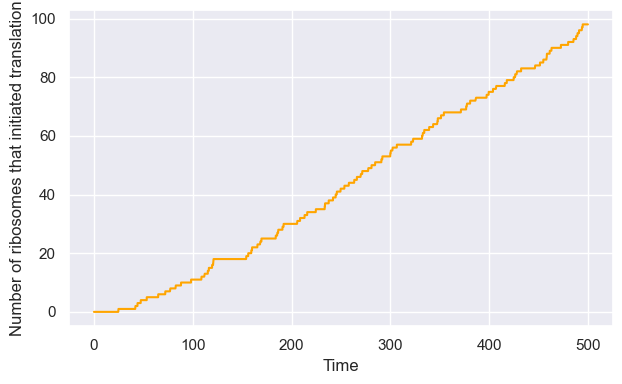

In [54]:
#INITIATED VS. TIME model_test
plt.figure(figsize = (12, 4))
plt.subplot(121)
sns.lineplot(x='time', y='passed_total', data=model_test, color='orange')

plt.xlabel('Time')
plt.ylabel('Number of ribosomes that initiated translation')

plt.tight_layout()
plt.show();

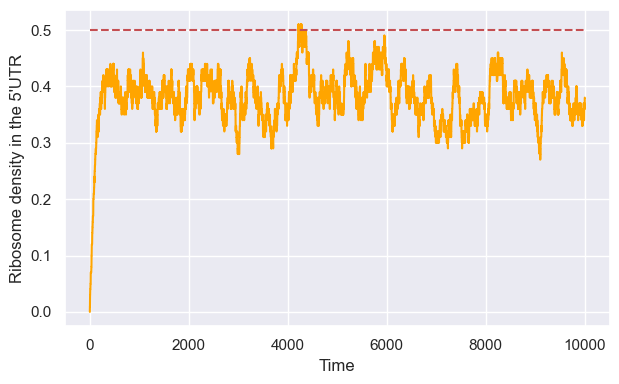

In [55]:
#DENSITY VS. TIME Max current (a and b >1/2)
#EXPECTED: d=1/2
plt.figure(figsize = (12, 4))
plt.subplot(121)
sns.lineplot(x='time', y='density', data=rini(t=10000, L=100), color='orange')
plt.plot([0,10000], [0.5,0.5], '--',color='r')

plt.xlabel('Time')
plt.ylabel("Ribosome density in the 5'UTR")

plt.tight_layout()
plt.show();

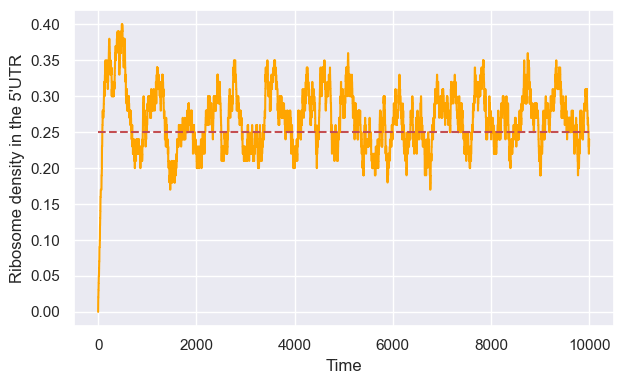

In [56]:
#DENSITY VS. TIME Low density (a < 1/2 and a < b)
#EXPECTED: d=a (0.25 here)
plt.figure(figsize = (12, 4))
plt.subplot(121)
sns.lineplot(x='time', y='density', data=rini(a=0.25, t=10000, L=100), color='orange')
plt.plot([0,10000], [0.25,0.25], '--',color='r')
plt.xlabel('Time')
plt.ylabel("Ribosome density in the 5'UTR")

plt.tight_layout()
plt.show();

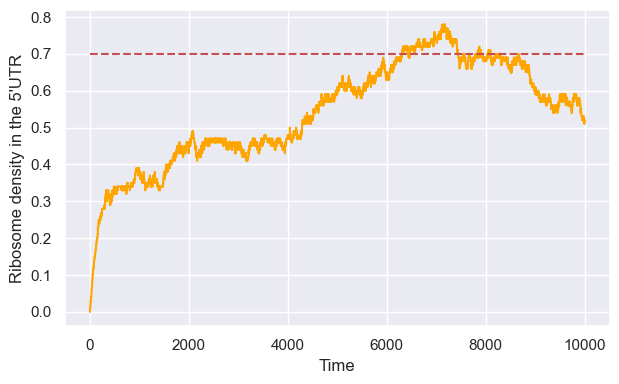

In [9]:
#DENSITY VS. TIME High density (b < 1/2 and a > b)
#EXPECTED: d=1-b (b=0.3 here so 0.7)
plt.figure(figsize = (12, 4))
plt.subplot(121)
sns.lineplot(x='time', y='density', data=rini(b=0.3,t=10000,L=200), color='orange')
plt.plot([0,10000], [0.7,0.7], '--',color='r')
plt.xlabel('Time')
plt.ylabel("Ribosome density in the 5'UTR")

plt.tight_layout()
plt.show();

100%|██████████| 50/50 [13:24<00:00, 16.10s/it]


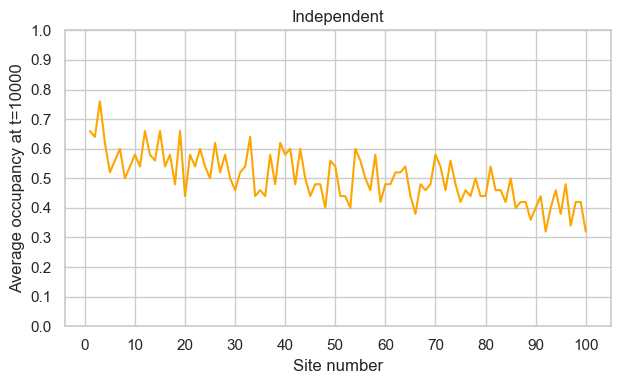

In [49]:
#FIRST RINI Vs. CORINI COMPARISON
#1: rinimo no block
rinimo(B_i=[])



100%|██████████| 50/50 [12:14<00:00, 14.70s/it]


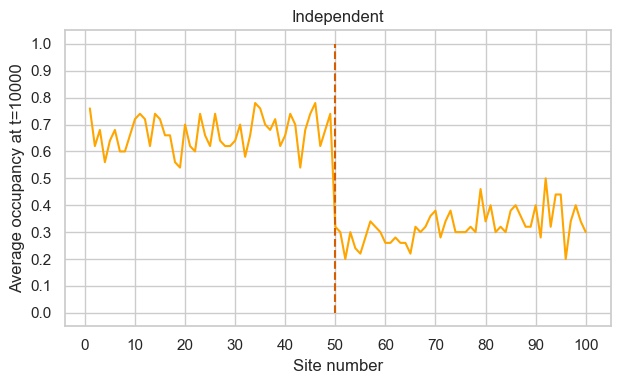

In [46]:
#2 rinimo 1 block
rinimo(B_i=[49])



100%|██████████| 50/50 [10:12<00:00, 12.26s/it]


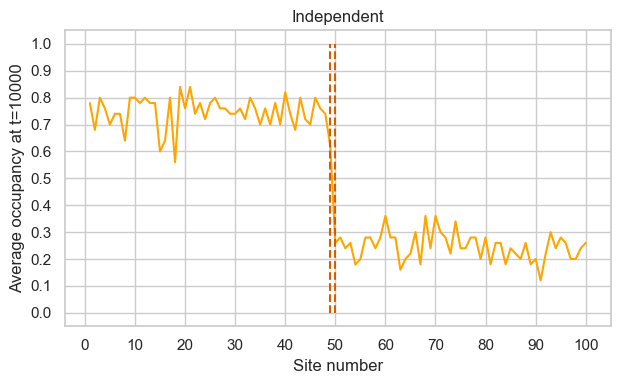

In [47]:
#2bis rinimo 2 blocks
rinimo(B_i=[48,49])

100%|██████████| 50/50 [12:12<00:00, 14.65s/it]


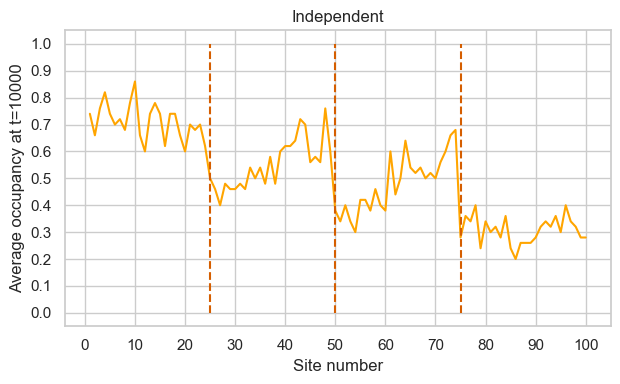

In [42]:
#3 rinimo 3 distant blocks
rinimo(B_i=[24,49,74])

100%|██████████| 50/50 [12:07<00:00, 14.54s/it]


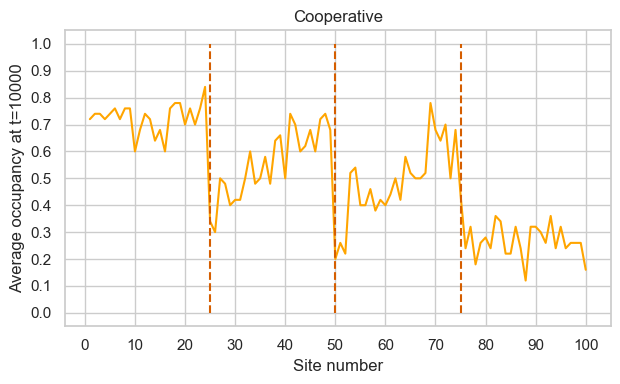

In [43]:
corinimo(B_i=[24,49,74])

100%|██████████| 50/50 [09:03<00:00, 10.86s/it]


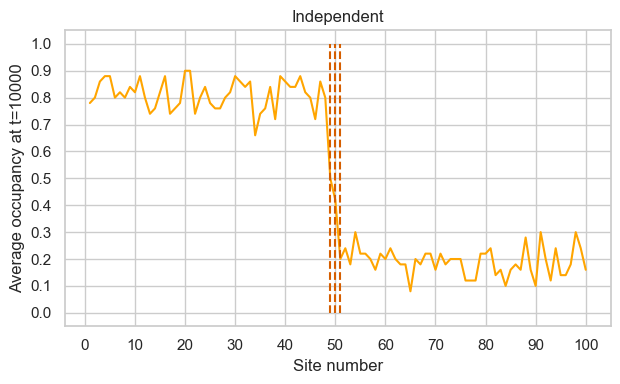

In [44]:
#3bis rinimo 3 close blocks
rinimo()

100%|██████████| 50/50 [03:13<00:00,  3.88s/it]


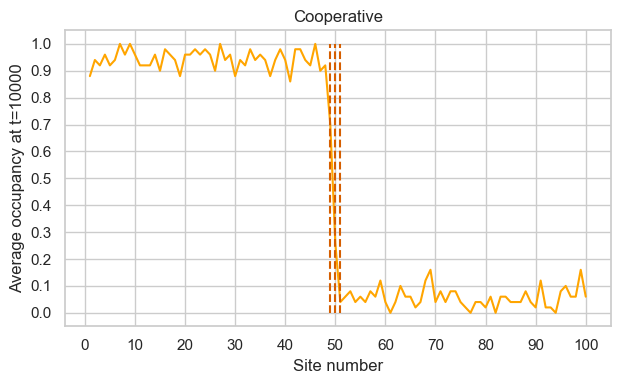

In [45]:
corinimo()